In [ ]:
import os
import json
import shutil
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from tensorflow import keras
from sklearn.datasets import load_files
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image                  
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

%matplotlib inline

#Checking GPU

In [ ]:
!nvidia-smi

Mon Apr 25 18:05:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Loading Dataset onto local environment

In [ ]:
!unzip -qq /content/drive/MyDrive/Workspace/imgs/Train.zip

In [ ]:
!unzip -qq /content/drive/MyDrive/Workspace/imgs/test.zip

#Creating workspace

In [ ]:
TRAIN_DIR = "/content/train"
MODEL_PATH = "/content/model/self_trained"
PICKLE_DIR = "/content/pickle_files"
CSV_DIR = "/content/csvs"
TEST_DIR = "/content/test"
PREDICT_DIR = "/content/preds"
JSON_DIR = "/content/json"

In [ ]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
if not os.path.exists(PICKLE_DIR):
    os.makedirs(PICKLE_DIR)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)
if not os.path.exists(PREDICT_DIR):
    os.makedirs(PREDICT_DIR)
else:
    shutil.rmtree(PREDICT_DIR)
    os.makedirs(PREDICT_DIR)
if not os.path.exists(JSON_DIR):
    os.makedirs(JSON_DIR)

#Reading the data

In [ ]:
def create_csv(DATA_DIR,filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR,class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR,class_name))
            for file in file_names:
                data.append({
                    "Filename":os.path.join(DATA_DIR,class_name,file),
                    "ClassName":class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "FileName":os.path.join(DATA_DIR,file),
                "ClassName":class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(os.path.join(os.getcwd(),"csvs",filename),index=False)

create_csv(TRAIN_DIR,"train.csv")
create_csv(TEST_DIR,"test.csv")
data_train = pd.read_csv(os.path.join(os.getcwd(),"csvs","train.csv"))
data_test = pd.read_csv(os.path.join(os.getcwd(),"csvs","test.csv"))

In [ ]:
data_train['ClassName'].value_counts()

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: ClassName, dtype: int64

In [ ]:
data_train.describe()

,Filename,ClassName
count,22424,22424
unique,22424,10
top,/content/train/c6/img_89295.jpg,c0
freq,1,2489


In [ ]:
data_train.head()

,Filename,ClassName
0,/content/train/c6/img_89295.jpg,c6
1,/content/train/c6/img_85731.jpg,c6
2,/content/train/c6/img_38634.jpg,c6
3,/content/train/c6/img_85357.jpg,c6
4,/content/train/c6/img_85169.jpg,c6


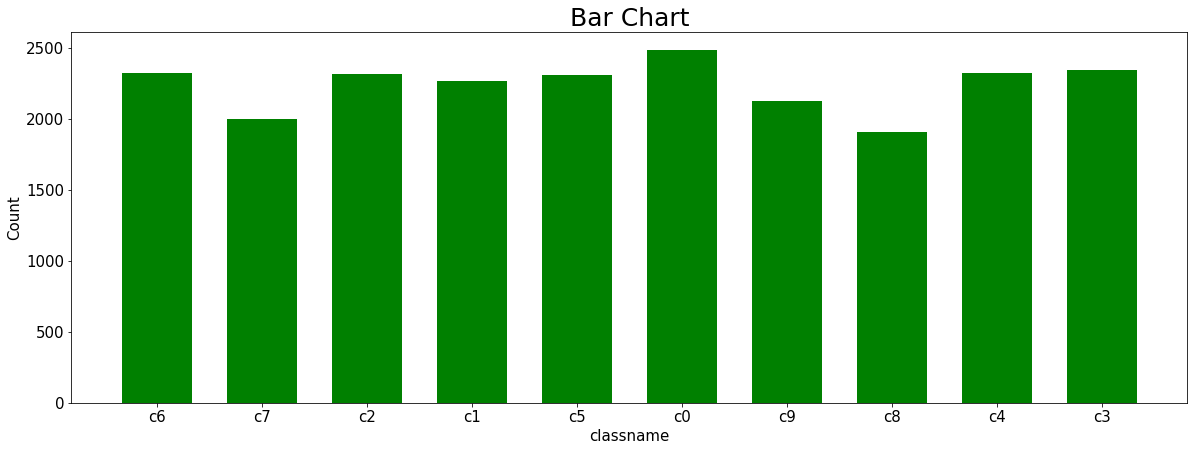

In [ ]:
nf = data_train['ClassName'].value_counts(sort=False)
labels = data_train['ClassName'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="green")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()

#Creating the labels

In [ ]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

{'c5': 0, 'c9': 1, 'c1': 2, 'c4': 3, 'c7': 4, 'c0': 5, 'c3': 6, 'c6': 7, 'c2': 8, 'c8': 9}


In [ ]:
with open(os.path.join(os.getcwd(),"pickle_files","labels_list.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

In [ ]:
labels = to_categorical(data_train['ClassName'])

In [ ]:
labels.shape

(22424, 10)

In [ ]:
labels

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#Segmentation and preprocessing of data

In [ ]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)

In [ ]:
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5

100%|██████████| 17939/17939 [01:35<00:00, 187.68it/s]


In [ ]:
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

100%|██████████| 4485/4485 [00:33<00:00, 134.64it/s]


#Defining and training the model

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(128,128,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

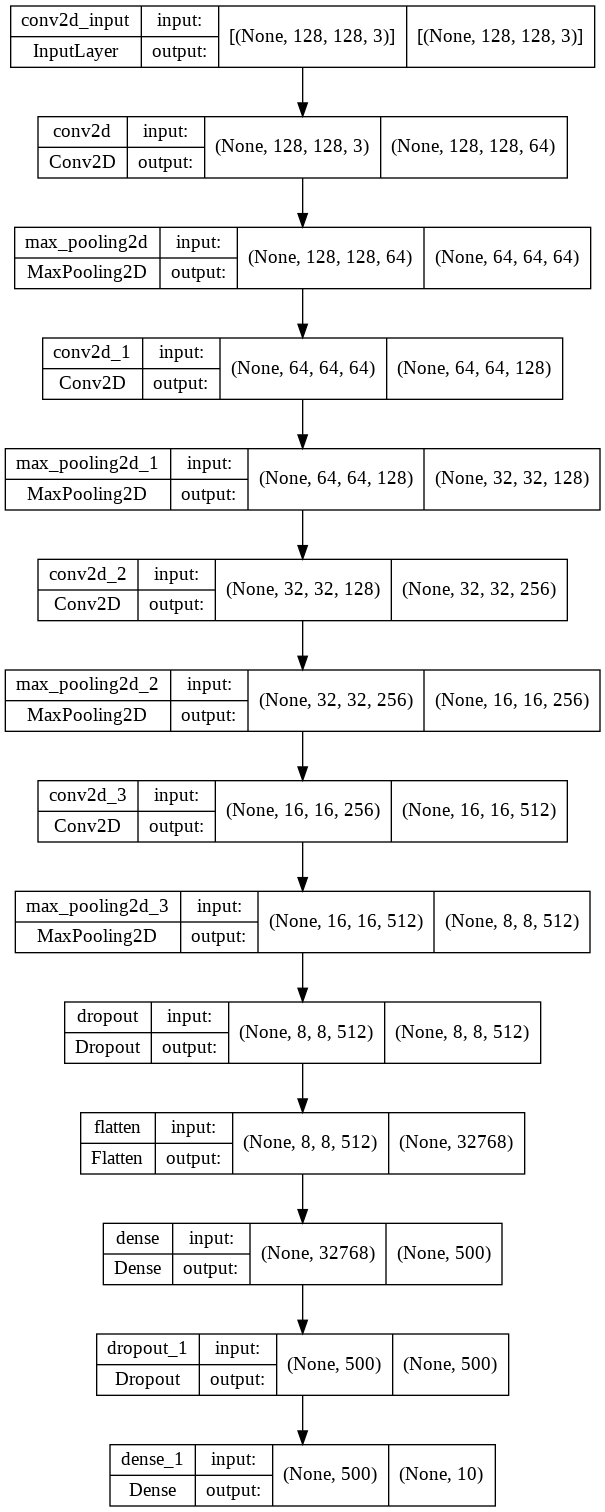

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [ ]:
model_history = model.fit(train_tensors,ytrain,validation_data = (valid_tensors, ytest),epochs=20, batch_size=40, shuffle=True,callbacks=callbacks_list)

Epoch 1/20
449/449 [==============================] - ETA: 0s - loss: 0.9728 - accuracy: 0.6755
Epoch 1: val_accuracy improved from -inf to 0.94916, saving model to /content/model/self_trained/distracted-01-0.95.hdf5
449/449 [==============================] - 84s 156ms/step - loss: 0.9728 - accuracy: 0.6755 - val_loss: 0.1843 - val_accuracy: 0.9492
Epoch 2/20
449/449 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9441
Epoch 2: val_accuracy improved from 0.94916 to 0.98038, saving model to /content/model/self_trained/distracted-02-0.98.hdf5
449/449 [==============================] - 61s 136ms/step - loss: 0.1879 - accuracy: 0.9441 - val_loss: 0.0738 - val_accuracy: 0.9804
Epoch 3/20
449/449 [==============================] - ETA: 0s - loss: 0.1035 - accuracy: 0.9701
Epoch 3: val_accuracy improved from 0.98038 to 0.98551, saving model to /content/model/self_trained/distracted-03-0.99.hdf5
449/449 [==============================] - 61s 136ms/step - loss: 0.1035 - 

#Analysis

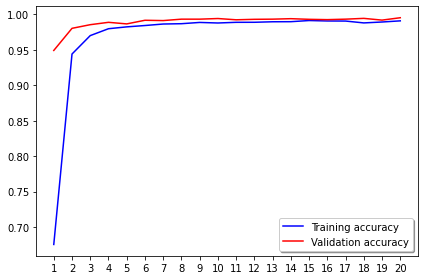

In [ ]:
plt.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")

legend = plt.legend(loc='lower right', shadow=True)
plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.tight_layout()
plt.show()

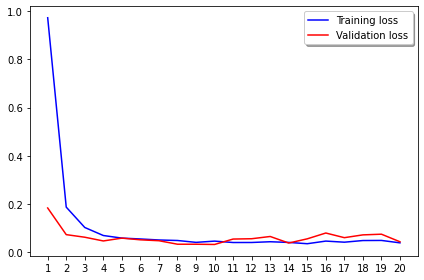

In [ ]:
plt.plot(model_history.history['loss'], color='b', label="Training loss")
plt.plot(model_history.history['val_loss'], color='r',label="Validation loss")

legend = plt.legend(loc='best', shadow=True)
plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.tight_layout()
plt.show()

#Confusion Matrix

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig

In [ ]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels 
    predictions = n_predictions 

    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [ ]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
ypred = model.predict(valid_tensors)

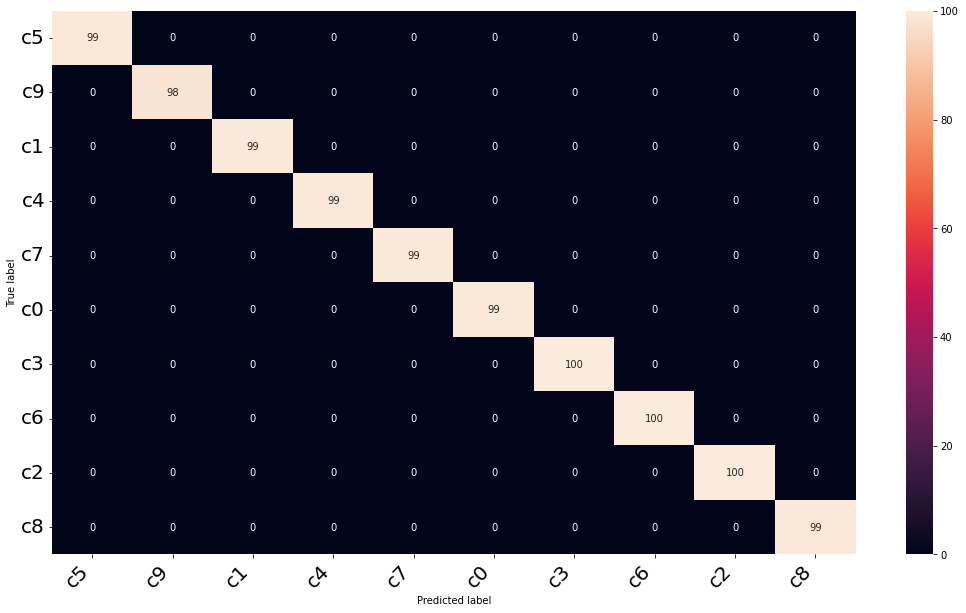

In [ ]:
print_heatmap(ytest,ypred,class_names)

#Accuracy on test data set

In [ ]:
ypred_class = np.argmax(ypred,axis=1)
ytest = np.argmax(ytest,axis=1)

In [ ]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.995318
Precision: 0.995337
Recall: 0.995318
F1 score: 0.995317


#Predicting on images using best model

In [ ]:
from keras.models import load_model
model = load_model(os.path.join(MODEL_PATH,"distracted-20-1.00.hdf5"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       32896     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       131328    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 256)      0

In [ ]:
data_test = pd.read_csv(os.path.join(CSV_DIR, "test.csv"))
data_test = data_test[:1000] 
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FileName   1000 non-null   object
 1   ClassName  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [ ]:
with open(os.path.join(PICKLE_DIR,"labels_list.pkl"),"rb") as handle:
    labels_id = pickle.load(handle)
print(labels_id)

{'c5': 0, 'c9': 1, 'c1': 2, 'c4': 3, 'c7': 4, 'c0': 5, 'c3': 6, 'c6': 7, 'c2': 8, 'c8': 9}


In [ ]:
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True  
test_tensors = paths_to_tensor(data_test.iloc[:,0]).astype('float32')/255 - 0.5

100%|██████████| 1000/1000 [00:07<00:00, 127.45it/s]


In [ ]:
ypred_test = model.predict(test_tensors,verbose=1)
ypred_class = np.argmax(ypred_test,axis=1)

id_labels = dict()
for class_name,idx in labels_id.items():
    id_labels[idx] = class_name
print(id_labels)

for i in range(data_test.shape[0]):
    data_test.iloc[i,1] = id_labels[ypred_class[i]]

32/32 [==============================] - 1s 44ms/step
{0: 'c5', 1: 'c9', 2: 'c1', 3: 'c4', 4: 'c7', 5: 'c0', 6: 'c3', 7: 'c6', 8: 'c2', 9: 'c8'}


In [ ]:
class_name = dict()
class_name["c0"] = "SAFE_DRIVING"
class_name["c1"] = "TEXTING_RIGHT"
class_name["c2"] = "TALKING_PHONE_RIGHT"
class_name["c3"] = "TEXTING_LEFT"
class_name["c4"] = "TALKING_PHONE_LEFT"
class_name["c5"] = "OPERATING_RADIO"
class_name["c6"] = "DRINKING"
class_name["c7"] = "REACHING_BEHIND"
class_name["c8"] = "HAIR_AND_MAKEUP"
class_name["c9"] = "TALKING_TO_PASSENGER"


with open(os.path.join(JSON_DIR,'class_name_map.json'),'w') as secret_input:
    json.dump(class_name,secret_input,indent=4,sort_keys=True)

In [ ]:
with open(os.path.join(JSON_DIR,'class_name_map.json')) as secret_input:
    info = json.load(secret_input)


for i in range(data_test.shape[0]):
    new_name = data_test.iloc[i,0].split("/")[-1].split(".")[0]+"_"+info[data_test.iloc[i,1]]+".jpg"
    shutil.copy(data_test.iloc[i,0],os.path.join(PREDICT_DIR,new_name))

data_test.to_csv(os.path.join(os.getcwd(),"csvs","short_test_result.csv"),index=False)